In [1]:
import xarray as xr
import rioxarray as rxr
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from pyeto import fao
import numpy as np

# Pull in boundary data

In [2]:
# LCC projection for the Upper Colorado River Basin
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" 

# Read in the UCRB boundary
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary_4326 = ucrb_boundary.copy()
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj) # reprojection to LCC

# Read in the HCDN boundaries
hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)
hcdn_boundaries_4326=hcdn_boundaries.to_crs(4326) # reprojection to 4326


# Pull in Terraclime data

In [3]:
terraclimate_pet = xr.open_dataset('../data/etdata/agg_terraclimate_pet_1958_CurrentYear_GLOBE.nc')
terraclimate_ppt = xr.open_dataset('../data/precipdata/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc')
terraclimate_tmin = xr.open_dataset('../data/etdata/agg_terraclimate_tmin_1958_CurrentYear_GLOBE.nc')
terraclimate_tmax = xr.open_dataset('../data/etdata/agg_terraclimate_tmax_1958_CurrentYear_GLOBE.nc')
# resample to daily data
# terraclimate_pet_daily = terraclimate_pet.resample(time='1D').interpolate('cubic')
# convert to a raster and change crs to match the UCRB boundary
terraclimate_pet = terraclimate_pet.rio.write_crs(4326)
terraclimate_ppt = terraclimate_ppt.rio.write_crs(4326)
terraclimate_tmin = terraclimate_tmin.rio.write_crs(4326)
terraclimate_tmax = terraclimate_tmax.rio.write_crs(4326)

### Set boundary to East River for basin specific analysis

In [4]:
tmp1 = hcdn_boundaries_4326[hcdn_boundaries_4326.gage == '09112500']
pet_trc = terraclimate_pet.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])
ppt_trc = terraclimate_ppt.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])
tmin_trc = terraclimate_tmin.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])
tmax_trc = terraclimate_tmax.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])

In [5]:
tmean_trc = (tmax_trc.tmax + tmin_trc.tmin)/2
tdiff_trc = tmax_trc.tmax - tmin_trc.tmin

In [6]:
spring_totals_terraclime_pet = pet_trc['pet'].where(pet_trc.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time').sel(year=slice(1989,2020))
spring_totals_terraclime_ppt = ppt_trc['ppt'].where(ppt_trc.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time').sel(year=slice(1989,2020))
spring_tmin_terraclime = tmin_trc.tmin.where(tmin_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tmax_terraclime = tmax_trc.tmax.where(tmax_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tmean_terraclime = (tmean_trc.where(tmean_trc.time.dt.month.isin([4,5,6]))).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tdiff_terraclime = tdiff_trc.where(tdiff_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))

spring_tmean_terraclime_anomaly = spring_tmean_terraclime - spring_tmean_terraclime.mean('year')

In [7]:
### save if needed
# pet_trc.resample(time='1D').interpolate('cubic').to_netcdf('../data/etdata/east_river_terraclime_pet.nc')
# pet_trc.to_netcdf('../data/etdata/east_river_terraclime_pet_monthly.nc')
# ppt_trc.to_netcdf('../data/precipdata/east_river_terraclime_ppt_monthly.nc')

### Set boundary to the UCRB

In [8]:
pet_ucrb = terraclimate_pet.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))
ppt_ucrb = terraclimate_ppt.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))
tmin_ucrb = terraclimate_tmin.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))
tmax_ucrb = terraclimate_tmax.rio.clip(ucrb_boundary_4326.geometry).sel(time=slice('1964-1-1','2022-9-30'))

In [9]:
tmean_ucrb = (tmax_ucrb.tmax + tmin_ucrb.tmin)/2
tdiff_ucrb = tmax_ucrb.tmax - tmin_ucrb.tmin

### TerraClimate Spring PET, PPT, and Temp

In [10]:
# TerraClimate PET and PPT for the UCRB
ucrb_spring_totals_terraclime_pet = pet_ucrb['pet'].where(pet_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time')
ucrb_spring_totals_terraclime_ppt = ppt_ucrb['ppt'].where(ppt_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time')

# TerraClimate TMIN and TMAX for the UCRB
ucrb_spring_tmin_terraclime = tmin_ucrb.tmin.where(tmin_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
ucrb_spring_tmax_terraclime = tmax_ucrb.tmax.where(tmax_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
# TerraClimate TMEAN and TDIFF for the UCRB
ucrb_spring_tmean_terraclime = (tmean_ucrb.where(tmean_ucrb.time.dt.month.isin([4,5,6]))).groupby('time.year').mean('time')
ucrb_spring_tdiff_terraclime = tdiff_ucrb.where(tdiff_ucrb.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time')
# TerraClimate temperature anomaly for the UCRB
ucrb_spring_tmean_terraclime_anomaly = ucrb_spring_tmean_terraclime - ucrb_spring_tmean_terraclime.mean('year')

In [11]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

### Correlation for TerraClimate PET

In [39]:
from scipy.stats.stats import pearsonr, spearmanr

corr_terraclimate = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_totals_terraclime_pet, ucrb_spring_totals_terraclime_ppt])
# convert to an xarray dataarray
corr_terraclimate = xr.DataArray(corr_terraclimate[0,:,:], dims=['lat','lon'], coords={'lat':ucrb_spring_totals_terraclime_pet.lat,'lon':ucrb_spring_totals_terraclime_pet.lon})
corr_terraclimate = corr_terraclimate.rio.set_crs(4326)
# convert to 32613
corr_terraclimate = corr_terraclimate.rio.reproject(32613)
# remove values above 1
corr_terraclimate = corr_terraclimate.where(corr_terraclimate<=1,drop=True)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [40]:
corr_terraclimate_temp = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_tmean_terraclime, ucrb_spring_totals_terraclime_ppt])
# convert to an xarray dataarray
corr_terraclimate_temp = xr.DataArray(corr_terraclimate_temp[0,:,:], dims=['lat','lon'], coords={'lat':ucrb_spring_totals_terraclime_ppt.lat,'lon':ucrb_spring_totals_terraclime_ppt.lon})
corr_terraclimate_temp = corr_terraclimate_temp.rio.set_crs(4326)
# convert to 32613
corr_terraclimate_temp = corr_terraclimate_temp.rio.reproject(32613)
# remove values above 1
corr_terraclimate_temp = corr_terraclimate_temp.where(corr_terraclimate_temp<=1,drop=True)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


# Pull in the PRISM Data to Estimate PET

### PRISM Thornthwaite Equation for East River

In [15]:
# get 4-km PRISM monthly temperature data over each HCDN Basin
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_all.nc') 
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True)

# set to a boundary just to test
tmp = hcdn_boundaries[hcdn_boundaries.gage == '09112500']
ucrb_temp = prism_tmean.rio.clip(tmp.geometry)
ucrb_temp = ucrb_temp.where(ucrb_temp>-100,drop=True)
mean_ucrb_temp = ucrb_temp.mean(dim=['x','y'])
spring_mean_ucrb_temp = mean_ucrb_temp.where(mean_ucrb_temp['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').mean()
spring_mean_ucrb_temp_anomaly = (spring_mean_ucrb_temp-spring_mean_ucrb_temp.mean(dim='year'))

# Get seasonal (months 1-4-7-10) prism precipitation and take a look at one of the values
prism_monthly_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc').sel(variable='09112500',dim_1='ppt')


In [16]:
# Calculate PET using thornthwaite equation
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad
lat = deg2rad(38.87626) 
thornthwaite_pet_df = pd.DataFrame(index=range(1987,2021), columns=range(1,13))
for year in range(1987,2021):
    mmdlh = monthly_mean_daylight_hours(lat, year=year)
    temp = mean_ucrb_temp.where(mean_ucrb_temp['month'].dt.year==year,drop=True)
    thornthwaite_pet_df.loc[year] = np.array(thornthwaite(temp.values, mmdlh))

### PRSIM UCRB Precipitation

In [17]:
# Open PRISM precipitation data
prism_ppt = rxr.open_rasterio('../data/precipdata/prism_4km_ucrb.nc')
# convert crs to match the UCRB boundary
prism_ppt = prism_ppt.rio.reproject(4326)
prism_ppt = prism_ppt.where(prism_ppt>=0,drop=True)

In [18]:
# Get seasonal total precipitation for the UCRB over spring
ucrb_spring_ppt = prism_ppt.where(prism_ppt['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').sum()
ucrb_spring_ppt = ucrb_spring_ppt.where(ucrb_spring_ppt>0,drop=True).sel(year=slice(1964,2022))

# Open PRISM temperature data
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_ucrb.nc')
# reprject to match the UCRB boundary
prism_tmean = prism_tmean.rio.reproject(4326)
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True).sel(month=slice('1964-01-01','2022-09-30'))
spring_mean_ucrb_temp = prism_tmean.where(prism_tmean['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').mean()

In [20]:
# add the year as a new dimension to prism_tmean
prism_tmean = prism_tmean.assign_coords(year=prism_tmean['month'].dt.year)
# make a copy to use later
prism_tmean_copy = prism_tmean.copy()
prism_tmean_copy['month'] = prism_tmean_copy['month'].dt.year

### PRISM UCRB Thornthwaite Estimate

In [21]:
# for each latitutde, calculate the thornthwaite p
latitudes = np.deg2rad(prism_tmean.y)
# calculate the mean daylight hours for each month
mmdlh = np.vstack([monthly_mean_daylight_hours(lat, year=2018)*59 for lat in latitudes])

# convert mmdlh to xarray to match the time dimension of prism_tmean
mmdlh = xr.DataArray(mmdlh[:,3:], dims=['y','month'], coords={'y':prism_tmean.y,'month':prism_tmean_copy.month})


In [22]:
def vectorize_thornthwaite_pet(tmean, N, _MONTHDAYS):
    """
    Vectorized version of the Thornthwaite PET equation. Input arrays must have the same dimensions. 
    Can be used to estimate PET from monthly mean temperature from PRISM and monthly mean daylight hours from latitude.
    Time index must be in years (e.g. 1987, 1988, 1989, etc.) repeated over for the number of each year's months (e.g. 1987, 1987, 1987, etc.)
    Inputs:
        tmean: mean monthly temperature (deg C), dimensions (time, lat, lon)
        N: mean monthly daylight hours (hours), dimensions (time, lat)  
        _MONTHDAYS: number of days in each month (days), dimensions (time)
    Returns:
        pet: monthly PET (mm/month)

    """
    # Negative temperatures should be set to zero
    adj_monthly_t = tmean * (tmean >= 0)
    # create empty arrays to be filled
    I = xr.zeros_like(adj_monthly_t)
    alpha = xr.zeros_like(adj_monthly_t)
    pet = xr.zeros_like(adj_monthly_t)
    # Iterate through each year
    for year in tmean.month.to_series().unique():
        # calculate the heat index for each year 
        I.loc[year] += (adj_monthly_t.where(adj_monthly_t>0).sel(month=year) / 5.0) ** 1.514
        # calculate the alpha multiplier for each year
        alpha.loc[year] = (6.75e-07 * I.loc[year].sum(dim='month') ** 3) - (7.71e-05 * I.loc[year].sum(dim='month') ** 2) + (1.792e-02 * I.loc[year].sum(dim='month') + 0.49239)
        # estimate PET using the Thornthwaite equation for each year
        pet.loc[year] = 16*(N.sel(month=year).transpose()/12)*(_MONTHDAYS.sel(month=year)/30)*(10*adj_monthly_t.sel(month=year)/I.loc[year].sum(dim='month'))**alpha.loc[year]
    return pet

In [23]:
# Calculate pet for each year at each grid cell
tmean = prism_tmean_copy
_MONTHDAYS = xr.DataArray(np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]*59)[:-3], dims=['month'], coords={'month':prism_tmean_copy.month})
# pet = np.zeros_like(tmean)
ucrb_prism_pet = vectorize_thornthwaite_pet(prism_tmean_copy, mmdlh,_MONTHDAYS)
ucrb_prism_pet['month'] = prism_tmean.month
# calculate the sum of PET over each spring period
ucrb_spring_pet = ucrb_prism_pet.where(ucrb_prism_pet['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').sum()
ucrb_spring_ppt = ucrb_spring_ppt.fillna(-9999)
ucrb_spring_pet = ucrb_spring_pet.fillna(-9999)

In [30]:
corr_prism = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_ppt, ucrb_spring_pet])
# convert to an xarray dataarray
corr_prism = xr.DataArray(corr_prism[0,:,:], dims=['y','x'], coords={'y':ucrb_spring_ppt.y,'x':ucrb_spring_ppt.x})
corr_prism = corr_prism.rio.set_crs(4326)
# convert to 32613
corr_prism = corr_prism.rio.reproject(32613)
# remove values above 1
corr_prism = corr_prism.where(corr_prism<=1,drop=True)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [38]:
corr_prism_temp = multi_apply_along_axis(pearsonr, 0, [ucrb_spring_ppt, spring_mean_ucrb_temp])
# convert to an xarray dataarray
corr_prism_temp = xr.DataArray(corr_prism_temp[0,:,:], dims=['y','x'], coords={'y':ucrb_spring_ppt.y,'x':ucrb_spring_ppt.x})
corr_prism_temp = corr_prism_temp.rio.set_crs(4326)
# convert to 32613
corr_prism_temp = corr_prism_temp.rio.reproject(32613)
# remove values above 1
corr_prism_temp = corr_prism_temp.where(corr_prism_temp<=1,drop=True)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [45]:
corr_terraclimate.mean()

<xarray.DataArray ()>
array(-0.66444509)
Coordinates:
    spatial_ref  int64 0

In [61]:
corr_terraclimate.min()


<xarray.DataArray ()>
array(-0.82383477)
Coordinates:
    spatial_ref  int64 0

In [62]:
src_4km = rxr.open_rasterio('../basin_characteristics/ucrb_dem_32613_150m.tif')
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
# downsample to 800m
src_4km = src_4km.rio.reproject(dst_crs='EPSG:32613', resolution=3945.843241747955)
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)

dx, dy =3945.843241747955,3945.843241747955

ucrb_boundary_32613 = ucrb_boundary_4326.to_crs(32613)
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

ucrb_stream_traces = gpd.read_file('../basin_characteristics/Colorado_River_Basin_Rivers.geojson')
ucrb_stream_traces = ucrb_stream_traces.to_crs(32613)
# clip to UCRB boundary
ucrb_stream_traces = gpd.clip(ucrb_stream_traces, ucrb_boundary_32613)

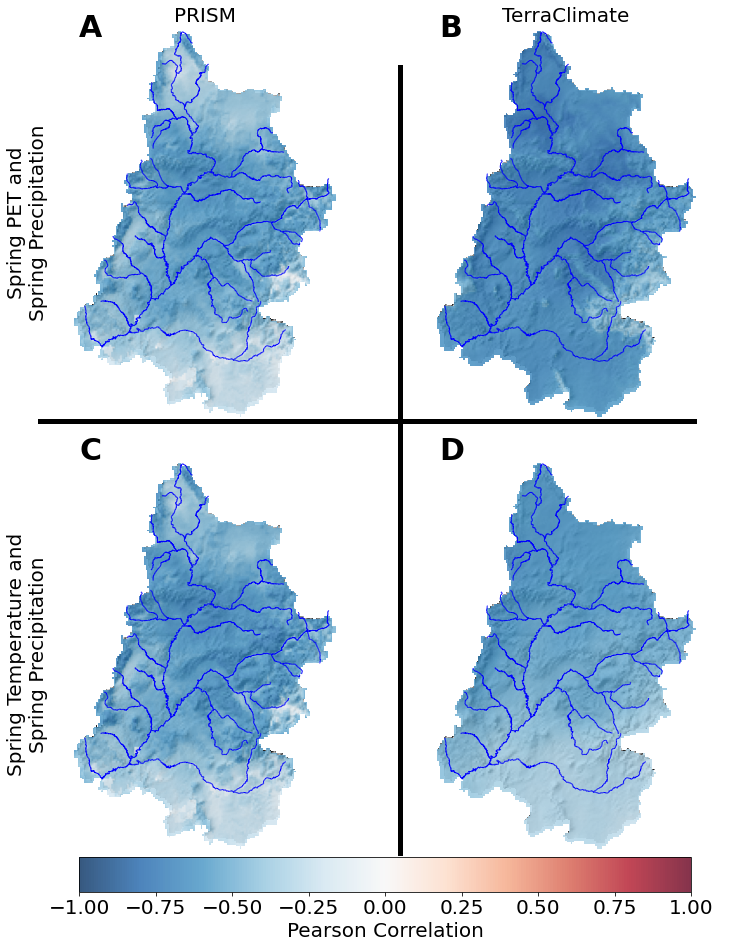

In [92]:
fig = plt.figure(figsize=(10, 12))
ax0 = plt.axes([0, 0, 1, 1])
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = plt.axes([0.05, 0.55, 0.45, 0.45])

ax2 = plt.axes([0.55, 0.55, 0.45, 0.45])

ax3 = plt.axes([0.05, 0.05, 0.45, 0.45])

ax4 = plt.axes([0.55, 0.05, 0.45, 0.45])

ax0.plot([0.55, 0.55], [0,1], color='black', lw=5)
ax0.plot([0, 1], [0.55, 0.55], color='black', lw=5)
ax0.set_axis_off()

ax=ax1
# add another plot for the annual mean
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_prism.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
ax.set_axis_off()
# add title to axs[4]
ax.set_title('PRISM', size=20)
# add vertical text along the side of axs[0]
ax.text(-0.1, 0.5, 'Spring PET and\nSpring Precipitation', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, size=20)

ax=ax2
# add another plot for the annual mean
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_terraclimate.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
ax.set_axis_off()
# add title to axs[4]
ax.set_title('TerraClimate', size=20)

ax=ax3
# add another plot for the annual mean
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_prism_temp.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
ax.set_axis_off()

# add vertical text along the side of axs[0]
ax.text(-0.1, 0.5, 'Spring Temperature and\nSpring Precipitation', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, size=20)

ax=ax4
# add another plot for the annual mean
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
im = ax.imshow(corr_terraclimate_temp.values, alpha=0.8, cmap='RdBu_r', vmin=-1, vmax=1,extent=[ucrb_boundary_32613.bounds.loc[0]['minx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['miny'], 
                                                                                                        ucrb_boundary_32613.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 

ax.axis('off')

# add title letters to upper left corner of each plot
ax0.text(0.1,0.99,'A',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
ax0.text(0.6,0.99,'B',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
ax0.text(0.1,0.5,'C',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
ax0.text(0.6,0.5,'D',size=30,transform=ax0.transAxes, fontdict={'weight':'bold'})
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
# create horizontal colorbar
cbar_ax = fig.add_axes([0.1,0.00, 0.85, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Pearson Correlation', size=20)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=20)
# fig.suptitle('Pearson Correlation Between Spring PET and Spring Precipitation\n1964-2022', size=24)
# add background whitespace
fig.patch.set_facecolor('white')

fig.savefig('../figures/pearson_correlation_spring_pet_spring_ppt.png', dpi=700, bbox_inches='tight')

# Pull in WRF data to estimate PET

In [11]:
wrf_ppt = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology_precip.nc')
spring_ppt = wrf_ppt.where(wrf_ppt['XTIME'].dt.month.isin([4,5,6]),drop=True).groupby('XTIME.year').sum()
mean_spring_ppt = spring_ppt.mean(dim=['south_north', 'west_east'])

In [14]:
# df = pd.DataFrame(columns=['value', 'year', 'month', 'variable'])
# for year in range(1987,2021):
#     print(f'Processing year {year}...')
#     example_ds = xr.open_mfdataset(f'/storage/dlhogan/sos/data/WRF/WY{year}/*.nc')
#     # resample to daily mean
#     ppt = example_ds.HR_PRCP.resample(XTIME='1M').sum().mean(dim=['south_north', 'west_east'])
#     # get the spatial average
#     example_ds = example_ds.mean(dim=['south_north', 'west_east']).resample(XTIME='1M').mean()

#     ### Calculate necessary variables for PET calculation
#     wm2_to_mj2day = 0.0864
#     # calculate net radiation
#     net_rad = fao.net_rad(ni_sw_rad = example_ds['SWDOWN']*wm2_to_mj2day,
#                 no_lw_rad = example_ds['GLW']*wm2_to_mj2day,)
#     # get average daily 2m temperature
#     t = example_ds['T2'].compute()
#     if year == 1987:
#         t_pre=280
#     else:
#         t_pre = t.values[0]

#     # get the arithmetic mean of U10 and V10 daily wind speed
#     u10 = example_ds['U10']
#     v10 = example_ds['V10']
#     ws = np.sqrt(u10**2 + v10**2)
#     # calculate the saturated vapor pressure
#     es = 6.11 * np.exp((2.5e6/461.5) * (1/273.15 - 1/(t.values))) # kilopascal
#     # calculate the actual vapor pressure
#     ea = (example_ds['Q2'] * example_ds['PSFC'] / (0.622 + 0.378 * example_ds['Q2'])).compute()/1000 # kiloPascal
#     # calculate the slope of the saturation vapor pressure curve
#     delta = 4098 * (0.6108 * np.exp(17.27 * (t.values-273.15) / (t.compute().values-35.86))) / (t.values-35.86)**2 
#     # calculate the psychrometric constant
#     psy = fao.psy_const(example_ds['PSFC']/1000).compute()
#     # calculate the mean soil flux estiamtion
#     pre_t = np.roll(t.values,1)
#     pre_t[0] = t_pre
#     sh = fao.monthly_soil_heat_flux2(pre_t-273.15,t.values-273.15)
#     # calculate the PET
#     pet = fao.fao56_penman_monteith(net_rad.values,
#                             t.values,
#                             ws.values,
#                             es,
#                             ea.values,
#                             delta,
#                             psy.values,
#                             shf=sh)  
#     # add ppt to df with measuuremnet = ppt and month going from 10,11,12,1,2,3,4,5,6,7,8,9
#     df = pd.concat([df,
#                     pd.DataFrame({'value':pet,'variable':'pet','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year}),
#                     pd.DataFrame({'value':ppt,'variable':'ppt','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year}),
#                     pd.DataFrame({'value':t.values,'variable':'t','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year})],
#                     ignore_index=True)

In [15]:
# df.to_csv('../data/etdata/east_river_pet_wrf.csv')
df = pd.read_csv('../data/etdata/east_river_pet_wrf.csv', index_col=0)

# Plot PET against Spring P colored by Tmean

In [47]:
spring_totals_terraclime_pet = pet_trc['pet'].where(pet_trc.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time').sel(year=slice(1989,2020))
spring_totals_terraclime_ppt = ppt_trc['ppt'].where(ppt_trc.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time').sel(year=slice(1989,2020))
spring_tmin_terraclime = tmin_trc.tmin.where(tmin_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tmax_terraclime = tmax_trc.tmax.where(tmax_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tmean_terraclime = (tmean_trc.where(tmean_trc.time.dt.month.isin([4,5,6]))).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tdiff_terraclime = tdiff_trc.where(tdiff_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))

spring_tmean_terraclime_anomaly = spring_tmean_terraclime - spring_tmean_terraclime.mean('year')

### Same plot but for spring PET and ET

In [18]:
import scipy.stats as stats

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


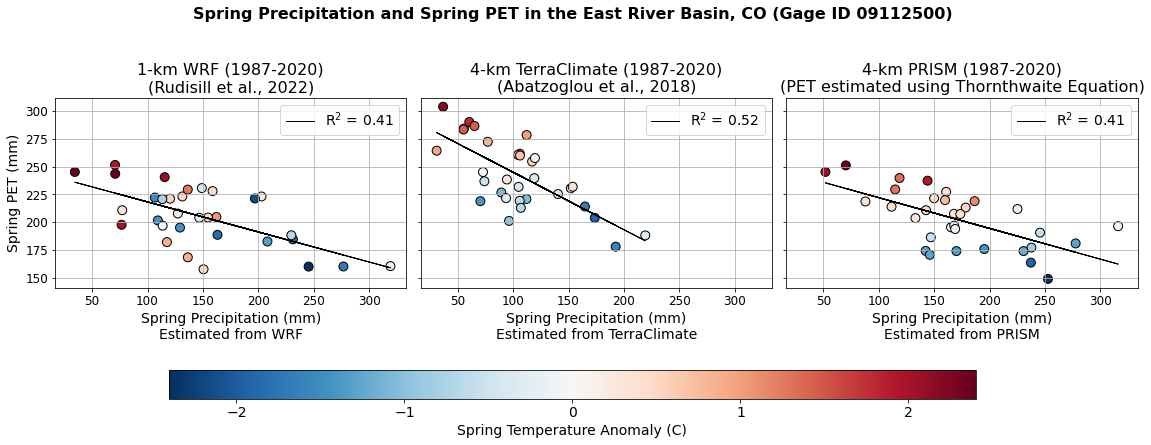

In [49]:
fig, axs = plt.subplots(ncols=3,figsize=(16,8), sharex=True, sharey=True, tight_layout=True)
# WRF Estimates
ax=axs[0]
# create the pivot table for spring conditions
spring_totals = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='sum').loc[1989:2020]
spring_total_temp = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='mean').loc[1989:2020]
spring_temperature_anomaly = spring_total_temp.t - spring_total_temp.t.mean()
# from the pivot table plot spring precipitation against spring pet
cax1 = ax.scatter(spring_totals['ppt'],
           spring_totals['pet']*3,
           c=spring_temperature_anomaly,
           cmap='RdBu_r',
           vmin=-2.4,
           vmax=2.4,
           s=80, 
           ec='k')

# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value1, std_err = stats.linregress(spring_totals['ppt'],spring_totals['pet']*3, alternative='less')
ax.plot(spring_totals['ppt'], slope*spring_totals['ppt']+ intercept, '-', color='k', linewidth=1, label='R$^2$ = '+str(round(r_value**2,2)))
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from WRF',fontsize=14)
ax.set_ylabel('Spring PET (mm)',fontsize=14)
ax.set_title('1-km WRF (1987-2020)\n(Rudisill et al., 2022)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

ax=axs[1]
# from the pivot table plot spring precipitation against spring pet
cax = ax.scatter(spring_totals_terraclime_ppt,
           spring_totals_terraclime_pet.values,
           c=spring_tmean_terraclime_anomaly,
           vmin=-2.4,
           vmax=2.4,
           cmap='RdBu_r',
           s=80, 
           ec='k')

# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_totals_terraclime_ppt,spring_totals_terraclime_pet, alternative='less')
ax.plot(spring_totals_terraclime_ppt, slope*spring_totals_terraclime_ppt + intercept, '-', color='k', linewidth=1, label='R$^2$ = '+str(round(r_value**2,2)))
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_title('4-km TerraClimate (1987-2020)\n(Abatzoglou et al., 2018)',fontsize=16)
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from TerraClimate',fontsize=14)
ax.legend(fontsize=14)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)

# PRISM Estimates
ax = axs[2]
prism_temperature_anomaly = spring_mean_ucrb_temp.sel(year=slice(1989,2020)) - spring_mean_ucrb_temp.sel(year=slice(1989,2020)).mean()
# from the pivot table plot spring precipitation against spring pet
cax1 = ax.scatter(mean_spring_ppt.sel(year=slice(1989,2020)).precip.values,
           1.33*thornthwaite_pet_df[[4,5,6]].sum(axis=1).loc[1989:],
           c=prism_temperature_anomaly,
           cmap='RdBu_r',
           vmin=-2.4,
           vmax=2.4,
           s=80, 
           ec='k')

# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value1, std_err = stats.linregress(mean_spring_ppt.sel(year=slice(1989,2020)).precip.values,1.33*thornthwaite_pet_df[[4,5,6]].sum(axis=1).loc[1989:], alternative='less')
ax.plot(mean_spring_ppt.sel(year=slice(1989,2020)).precip.values, slope*mean_spring_ppt.sel(year=slice(1989,2020)).precip.values + intercept, '-', color='k', linewidth=1, label='R$^2$ = '+str(round(r_value**2,2)))
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from PRISM',fontsize=14)
# ax.set_ylabel('Spring PET (Thornthwaite) (mm)',fontsize=14)
ax.set_title('4-km PRISM (1987-2020)\n(PET estimated using Thornthwaite Equation)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

# increase the white space between the title and the subplots
plt.subplots_adjust(wspace=0.05)
fig.suptitle('Spring Precipitation and Spring PET in the East River Basin, CO (Gage ID 09112500)',fontsize=16, fontweight='bold', y=0.8)
# add colorbar on the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.12, 0.7, 0.05])
cbar = plt.colorbar(cax1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Spring Temperature Anomaly (C)',fontsize=14)
# increase the ticklabel size for the colorbar
cbar.ax.tick_params(labelsize=14)
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)
    if ax == axs[0]:
      ax.set_ylabel('Spring PET (mm)',fontsize=14)
   #  ax.set_xlabel('Spring Precipitation (mm)',fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.legend(fontsize=14)
    ax.grid()

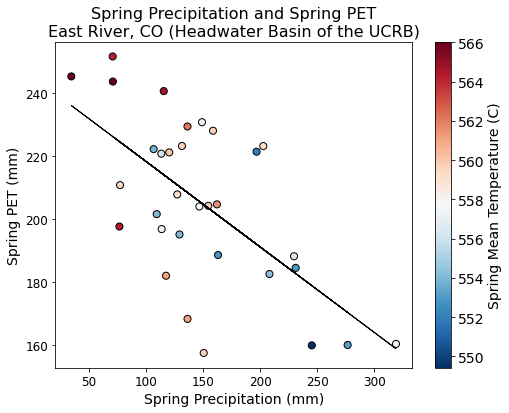

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
# create the pivot table for spring conditions
spring_totals = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='sum').loc[1989:]
spring_total_temp = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='mean').loc[1989:]
# from the pivot table plot spring precipitation against spring pet
cax = ax.scatter(spring_totals.ppt,
           spring_totals.pet*3,
           c=spring_totals.t-273.15,
           cmap='RdBu_r',
           s=50, 
           ec='k')
# add a colorbar
cbar = plt.colorbar(cax)
cbar.set_label('Spring Mean Temperature (C)',fontsize=14)
# increase the ticklabel size for the colorbar
cbar.ax.tick_params(labelsize=14)
# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_totals.ppt,spring_totals.pet*3)
m, b = np.polyfit(spring_totals.ppt,spring_totals.pet*3, 1)
ax.plot(spring_totals.ppt, m*spring_totals.ppt + b, '-', color='k', linewidth=1)
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)',fontsize=14)
ax.set_ylabel('Spring PET (mm)',fontsize=14)
ax.set_title('Spring Precipitation and Spring PET\nEast River, CO (Headwater Basin of the UCRB)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_ylim(50,90)

0.969788248732122
0.7684024187469468


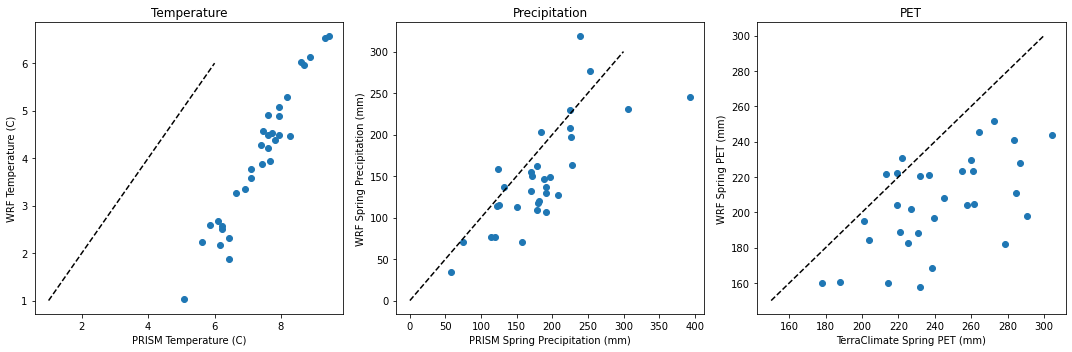

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].scatter(spring_mean_ucrb_temp.sel(year=slice(1989,2020)), spring_total_temp['t']-273.15, label='T')
# pearson correlation
r, p = stats.pearsonr(spring_mean_ucrb_temp.sel(year=slice(1989,2020)), spring_total_temp['t']-273.15)
print(r)
axs[0].plot([1, 6], [1, 6], 'k--')
axs[0].set_xlabel('PRISM Temperature (C)')
axs[0].set_ylabel('WRF Temperature (C)')
axs[0].set_title('Temperature')

axs[1].scatter(east_river_prism_spring_ppt[2:-2], spring_totals['ppt'])
axs[1].plot([0, 300], [0, 300], 'k--')
axs[1].set_xlabel('PRISM Spring Precipitation (mm)')
axs[1].set_ylabel('WRF Spring Precipitation (mm)')
axs[1].set_title('Precipitation')
# pearson correlation
r, p = stats.pearsonr(east_river_prism_spring_ppt[2:-2], spring_totals['ppt'])
print(r)
axs[2].scatter(spring_totals_terraclime_pet, spring_totals['pet']*3)
axs[2].plot([150, 300], [150, 300], 'k--')
axs[2].set_xlabel('TerraClimate Spring PET (mm)')
axs[2].set_ylabel('WRF Spring PET (mm)')
axs[2].set_title('PET')

# make the plot look nice
plt.tight_layout()


In [22]:
prism_spring_ppt = prism_monthly_ppt['__xarray_dataarray_variable__'].where(prism_monthly_ppt['month'].dt.month.isin([4])).groupby('month.year').sum('month')

In [23]:
prism_spring_ppt

<xarray.DataArray '__xarray_dataarray_variable__' (year: 128)>
array([219.39227295, 147.60429382, 193.87194824, 167.29646301,
       124.7022934 , 343.01257324, 264.53308105, 134.95033264,
       161.97695923, 209.71859741, 319.22412109, 219.52304077,
       220.09590149, 179.03155518, 163.62626648, 118.69290924,
       151.19822693, 201.59307861, 146.55693054, 217.81384277,
       197.1736908 , 119.03964233, 191.48355103, 159.44163513,
       122.24517822, 225.08540344, 244.54833984, 165.04008484,
       173.70599365, 138.10528564, 113.2252121 , 222.92445374,
       173.73904419, 210.27836609, 126.60801697, 106.61123657,
       152.37284851, 154.67030334, 217.55079651, 100.79574585,
       303.39028931, 137.93280029, 177.89738464, 282.81448364,
        79.36833954, 137.39013672, 231.46360779, 198.25741577,
       173.37117004, 266.70925903, 193.76249695, 214.56297302,
       320.97610474, 243.72651672, 211.84848022, 144.72361755,
       239.36413574, 126.17362213, 212.22723389, 104.96327972,
       148.5227356 , 139.92488098, 342.90509033, 140.72187805,
       205.72633362, 108.51711273, 193.41418457, 187.39698792,
       116.49523163, 192.52383423, 206.26748657, 171.5       ,
       196.83358765, 147.04719543, 232.40240479, 198.1242218 ,
       149.59745789, 177.46374512, 244.28723145, 161.95948792,
       163.57569885, 137.88146973, 131.7023468 , 180.94975281,
       228.6937561 , 169.41796875, 217.68664551, 148.07722473,
       334.7862854 , 322.56497192, 236.12812805, 222.5198822 ,
       132.50640869, 161.00164795, 113.92868042, 183.50294495,
       191.17182922, 179.4776001 , 227.3445282 , 177.95184326,
       393.7897644 , 169.48959351, 252.80996704, 191.27253723,
       306.93130493, 157.4598999 , 191.35449219,  57.79572296,
       207.99324036, 169.39666748, 188.7718811 , 120.08251953,
       132.17991638, 178.49324036, 225.05078125, 197.32672119,
       226.85133362,  74.01044464, 182.01896667, 150.55526733,
       238.73526001, 170.80326843, 122.61911774, 124.73542023,
       224.92695618, 123.7173233 , 117.88620758, 132.83822632])
Coordinates:
    dim_1     <U3 'ppt'
    variable  <U8 '09112500'
  * year      (year) int64 1895 1896 1897 1898 1899 ... 2018 2019 2020 2021 2022

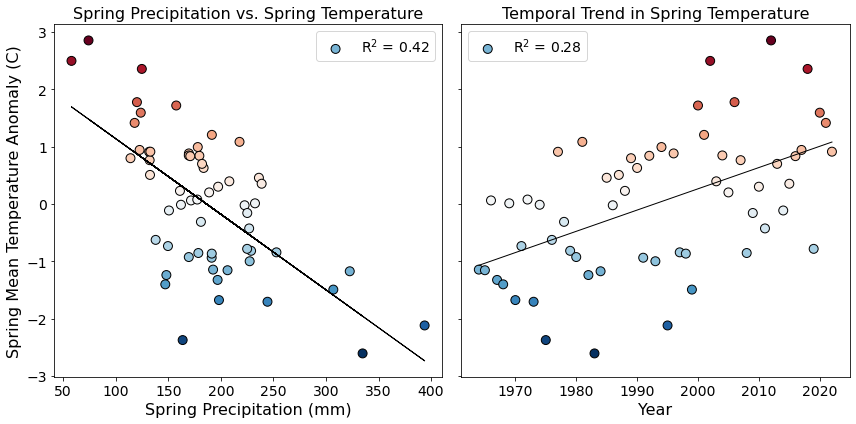

In [50]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6), sharey=True, tight_layout=True)
years_of_interest=slice(1964,2022)
ax=axs[0]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_spring_ppt.sel(year=years_of_interest),spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest))
ax.scatter(prism_spring_ppt.sel(year=years_of_interest),spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest),
           c=spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest),
           cmap='RdBu_r', 
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
ax.plot(prism_spring_ppt.sel(year=years_of_interest), slope*prism_spring_ppt.sel(year=years_of_interest) + intercept, '-', color='k', linewidth=1)
ax.legend(fontsize=14)
ax.set_ylabel('Spring Mean Temperature Anomaly (C)',size=16)
ax.set_xlabel('Spring Precipitation (mm)',size=16)
ax.set_title('Spring Precipitation vs. Spring Temperature',size=16)

ax=axs[1]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest).year,spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest))
ax.scatter(spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest).year,
           spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest), 
           c=spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest),
           cmap='RdBu_r', 
           ec='k',
           s=80,
           label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
ax.plot(spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest).year, slope*spring_mean_ucrb_temp_anomaly.sel(year=years_of_interest).year + intercept, '-', color='k', linewidth=1)
ax.legend(fontsize=14)
ax.set_xlabel('Year',size=16)
# ax.set_ylabel('Spring Mean Temperature Anomaly (C)',size=16)
ax.set_title('Temporal Trend in Spring Temperature',size=16)
# increase the ticklabel size for x and y axes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)